In [1]:
# -- manuscript Figure 1 -- 
import numpy as np
import xarray as xr
from scipy.io import loadmat
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import sys
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def seasonal_cycle(x,a,b,c,d,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + f 
def seasonal_plus_trend(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 

In [3]:
# -- MERGE large AVISO datasets for a zoomed out view 
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1993_1998.nc'
av1 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1999_2004.nc'
av2 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2005_2010.nc'
av3 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2011_2016.nc'
av4 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2017_2021.nc'
av5 = xr.open_dataset(av_path)
av_tot = xr.concat([av1,av2,av3,av4,av5], dim='time')

In [4]:
# AVISO SLA 
avsla_raw = av_tot.sla
# --- remove spatial mean from each time 
# avsla_raw = avsla_raw - msl
# --- remove time mean (if generating master time series plot )
avsla_raw_mean = avsla_raw.sel(time=slice("1993-01-01", "2021-08-02")).mean(dim='time')
avsla_raw = avsla_raw - avsla_raw_mean
# --- extract times over 3 decades and full record
avsla_trend_time_1 = av_tot.time.sel(time=slice("1993-01-01", "2002-12-31"))   # oldest ten
avsla_trend_time_2 = av_tot.time.sel(time=slice("2008-01-01", "2017-12-31"))   # ecco ten
avsla_trend_time_3 = av_tot.time.sel(time=slice("2010-06-30", "2020-06-30"))   # ten of interest 
avsla_trend_time_tot = av_tot.time.sel(time=slice("1993-01-01", "2021-08-02")) # total
# -- extract sla over desired times -- 
# - first decade 
avsla_raw_1 = avsla_raw.sel(time=slice("1993-01-01", "2002-12-31"))
# - second decade (special decade)
avsla_raw_2 = avsla_raw.sel(time=slice("2008-01-01", "2017-12-31"))
avsla_raw_2_mean = avsla_raw_2.mean(dim='time')
avsla_raw_2_a = avsla_raw_2 - avsla_raw_2_mean
# - third decade 
avsla_raw_3 = avsla_raw.sel(time=slice("2010-06-30", "2020-06-30"))
# - full record 
avsla_raw_tot = avsla_raw.sel(time=slice("1993-01-01", "2021-08-02"))
avsla_raw_tot_mean = avsla_raw_tot.mean(dim='time')
avsla_raw_tot_a = avsla_raw_tot - avsla_raw_tot_mean

In [6]:
time_ord_1 = np.nan*np.ones(len(avsla_trend_time_1))
for i in range(len(avsla_trend_time_1)):
    ts = (np.datetime64(str(avsla_trend_time_1[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord_1[i] = ts/(60*60*24)
time_ord_2 = np.nan*np.ones(len(avsla_trend_time_2))
for i in range(len(avsla_trend_time_2)):
    ts = (np.datetime64(str(avsla_trend_time_2[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord_2[i] = ts/(60*60*24)
time_ord_3 = np.nan*np.ones(len(avsla_trend_time_3))
for i in range(len(avsla_trend_time_3)):
    ts = (np.datetime64(str(avsla_trend_time_3[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord_3[i] = ts/(60*60*24)
time_ord_tot = np.nan*np.ones(len(avsla_trend_time_tot))
for i in range(len(avsla_trend_time_tot)):
    ts = (np.datetime64(str(avsla_trend_time_tot[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord_tot[i] = ts/(60*60*24)

In [40]:
# --- AVISO remove seasonal cycle -- 
# avsla_1_wos = avsla_raw_1.copy(); avsla_1_wos_sm = avsla_raw_1.copy()
aviso_1_sla_trend = np.nan*avsla_raw_1[0].copy()
filt_len = 30 # boxcar filter (units = days), make even number
for i in range(len(avsla_raw_1.latitude)):
    for j in range(len(avsla_raw_1.longitude)):
        if np.sum(np.isnan(avsla_raw_1[:,i,j].data)) < 1:
            sm = np.convolve((1/filt_len)*np.ones(filt_len),avsla_raw_1[:,i,j])
            fit = curve_fit(seasonal_plus_trend, time_ord_1 - time_ord_1[0], sm[np.int(filt_len/2):-np.int(filt_len/2)+1])
            aviso_1_sla_trend[i,j] = fit[0][4]
            # model = seasonal_cycle((time_ord_1 - time_ord_1[0]),*fit[0])
            # avsla_1_wos[:,i,j] = avsla_raw_1[:,i,j] - model        
            # sm = np.convolve((1/filt_len)*np.ones(filt_len),avsla_1_wos[:,i,j])
            # avsla_1_wos_sm[:,i,j] = sm[np.int(filt_len/2):-np.int(filt_len/2)+1]

In [26]:
# -- what does fit look like -- 
# recon = seasonal_plus_trend((time_ord_1 - time_ord_1[0]),*fit[0])
# f, ax = plt.subplots(1,1,figsize=(10,3))
# ax.plot(time_ord_1,sm[np.int(filt_len/2):-np.int(filt_len/2)+1])
# ax.plot(time_ord_1,recon)

In [25]:
# avsla_2_wos = avsla_raw_2.copy(); avsla_2_wos_sm = avsla_raw_2.copy()
aviso_2_sla_trend = np.nan*avsla_raw_2[0].copy()
filt_len = 30 # boxcar filter (units = days), make even number
for i in range(len(avsla_raw_2.latitude)):
    for j in range(len(avsla_raw_2.longitude)):
        if np.sum(np.isnan(avsla_raw_2[:,i,j].data)) < 1:
            sm = np.convolve((1/filt_len)*np.ones(filt_len),avsla_raw_2[:,i,j])
            fit = curve_fit(seasonal_plus_trend, time_ord_2 - time_ord_2[0], sm[np.int(filt_len/2):-np.int(filt_len/2)+1])
            aviso_2_sla_trend[i,j] = fit[0][4]
            
            # fit = curve_fit(seasonal_cycle, time_ord_2 - time_ord_2[0], avsla_raw_2[:,i,j])
            # model = seasonal_cycle((time_ord_2 - time_ord_2[0]),*fit[0])
            # avsla_2_wos[:,i,j] = avsla_raw_2[:,i,j] - model
            # sm = np.convolve((1/filt_len)*np.ones(filt_len),avsla_2_wos[:,i,j])
            # avsla_2_wos_sm[:,i,j] = sm[np.int(filt_len/2):-np.int(filt_len/2)+1]

In [28]:
# -- test figure -- 
# clim = [-0.02, 0.02]; colMap = plt.get_cmap('RdBu_r',16); ax_x = [-98.5,-35]; ax_y = [15,60]; 
# f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)});
# Kc = (aviso_2_sla_trend*365).plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0],vmax=clim[-1],cmap=colMap)
# ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines(); # ax.set_xlim(ax_x); ax.set_ylim(ax_y);
# gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = False; gl.xlabels_bottom = False;

In [29]:
# avsla_3_wos = avsla_raw_3.copy(); avsla_3_wos_sm = avsla_raw_3.copy()
aviso_3_sla_trend = np.nan*avsla_raw_3[0].copy()
filt_len = 30 # boxcar filter (units = days), make even number
for i in range(len(avsla_raw_3.latitude)):
    for j in range(len(avsla_raw_3.longitude)):
        if np.sum(np.isnan(avsla_raw_3[:,i,j].data)) < 1:
            sm = np.convolve((1/filt_len)*np.ones(filt_len),avsla_raw_3[:,i,j])
            fit = curve_fit(seasonal_plus_trend, time_ord_3 - time_ord_3[0], sm[np.int(filt_len/2):-np.int(filt_len/2)+1])
            aviso_3_sla_trend[i,j] = fit[0][4]
    
            # fit = curve_fit(seasonal_cycle, time_ord_3 - time_ord_3[0], avsla_raw_3[:,i,j])
            # model = seasonal_cycle((time_ord_3 - time_ord_3[0]),*fit[0])
            # avsla_3_wos[:,i,j] = avsla_raw_3[:,i,j] - model
            # sm = np.convolve((1/filt_len)*np.ones(filt_len),avsla_3_wos[:,i,j])
            # avsla_3_wos_sm[:,i,j] = sm[np.int(filt_len/2):-np.int(filt_len/2)+1]

In [30]:
aviso_tot_sla_trend = np.nan*avsla_raw_tot[0].copy()
filt_len = 30 # boxcar filter (units = days), make even number
for i in range(len(avsla_raw_tot.latitude)):
    for j in range(len(avsla_raw_tot.longitude)):
        if np.sum(np.isnan(avsla_raw_tot[:,i,j].data)) < 1:
            sm = np.convolve((1/filt_len)*np.ones(filt_len),avsla_raw_tot[:,i,j])
            fit = curve_fit(seasonal_plus_trend, time_ord_tot - time_ord_tot[0], sm[np.int(filt_len/2):-np.int(filt_len/2)+1])
            aviso_tot_sla_trend[i,j] = fit[0][4]

In [ ]:
# --- AVISO smoothing 1.5 years? 

In [48]:
# --- AVISO fit linear trends to each -- 
# pavsla_1 = avsla_1_wos_sm.polyfit(dim='time', deg=1)
# pavsla_2 = avsla_2_wos_sm.polyfit(dim='time', deg=1) # (avsla_raw_2_a) fitting the anomaly here! 
# pavsla_3 = avsla_3_wos_sm.polyfit(dim='time', deg=1) 
# pavsla_tot = avsla_raw_tot.polyfit(dim='time', deg=1)
# aviso_1_sla_trend = pavsla_1.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
# aviso_2_sla_trend = pavsla_2.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
# aviso_3_sla_trend = pavsla_3.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
# aviso_tot_sla_trend = pavsla_tot.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
# avsla_trend_1 = xr.polyval(avsla_raw_1['time'], pavsla_1.polyfit_coefficients)
# avsla_trend_2 = xr.polyval(avsla_raw_2['time'], pavsla_2.polyfit_coefficients)
# avsla_trend_3 = xr.polyval(avsla_raw_3['time'], pavsla_3.polyfit_coefficients)

In [31]:
# -- Tide Gauge -- 
# - altimeter era - 
tg_data_l = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_long.mat') # FULL ECCO RECORD PLUS 
tg_heights_l_0 = tg_data_l['height_grid']/1000
filt_len = 30 # boxcar filter 
tg_heights_l = np.nan*np.ones(np.shape(tg_heights_l_0))
for i in range(np.shape(tg_heights_l)[0]):
    tf = np.convolve((1/30)*np.ones(30),tg_heights_l_0[i,:])
    tg_heights_l[i,:] = tf[np.int(filt_len/2):-np.int(filt_len/2)+1]

t_rec_l = []; 
for i in range(len(tg_data_l['t_grid'][0,:])):
    t_i_l = datetime.fromordinal(tg_data_l['t_grid'][0,i] - 366)
    t_rec_l.append(t_i_l)
data_da_l = xr.DataArray(data=tg_heights_l, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data_l['ID'][0,:]), time=(["time"], t_rec_l),
                            lon=(['location'], tg_data_l['lon'][0,:]), lat=(['location'], tg_data_l['lat'][0,:]),
                        ),        
                       )
# - 40 YEAR - 
tg_data_xl = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_verylong_1970_2021.mat')
t_rec_xl = []; 
for i in range(len(tg_data_xl['t_grid'][0,:])):
    t_i_xl = datetime.fromordinal(tg_data_xl['t_grid'][0,i] - 366)
    t_rec_xl.append(t_i_xl)
data_da_xl = xr.DataArray(data=tg_data_xl['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data_xl['ID'][0,:]), time=(["time"], t_rec_xl),
                            lon=(['location'], tg_data_xl['lon'][0,:]), lat=(['location'], tg_data_xl['lat'][0,:]),
                        ),        
                       )
id_tags = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE STATE DOCKS', 'BAY WAVELAND' ,'SHELL BEACH', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON II PIER', \
          'USCG FREEPORT', 'CORPUS CHRISTI', 'PORT ISBEL']

# - subset to remove mean from all years 
# t_s = '1970-01-15'; t_e = '2020-12-31'
t_s = '1993-01-01'; t_e = '2017-12-31'
tg_xl = data_da_xl.sel(time=slice('1980-01-01', '2020-12-31'))
tg_xl_a = tg_xl - data_da_xl.sel(time=slice(t_s, t_e)).mean(dim='time') # relative to 1993-2017 mean - to align with ECCO and altimeter

# data is really at monthly resolution so this shouldn't do anything 
# tg_smooth = np.convolve((1/30)*np.ones(30),data_da_xl.sel(location=ids[3]) - np.nanmean(data_da_l.sel(location=ids[3])))
# tg_smooth = tg_smooth[np.int(filt_len/2):-np.int(filt_len/2)+1]

In [32]:
# -- Vertical Land Motion -- from multiple stations interpolated to tide gauge sites (better data)
file_int = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vlm_at_psmsl_gauges.txt")
data_int = file_int.readlines(); file_int.close()
name = []; name_row = []
for i in range(len(data_int)):
    if data_int[i][0] == '>':
        for j in range(len(data_int[i])):
            if data_int[i][j] == '\n':
                ee = j
                break
        name.append(data_int[i][9:ee])
        name_row.append(i)
        
# -- processing to get one number per tide gauge site 
id_tags_vlm = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY, ST.ANDREWS BAY, FL', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE STATE DOCKS, ALABAMA', 'BAY WAVELAND YACHT CLUB' ,'SHELL BEACH, LOUISIANA', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON II, PIER 21, TX', \
          'FREEPORT', 'CORPUS CHRISTI, GULF MEXICO, TX', 'PORT ISABEL']
vlm_rate = np.nan*np.ones(len(id_tags_vlm))
vlm_un = np.nan*np.ones(len(id_tags_vlm))
for i in range(len(id_tags_vlm)):
    ii = name.index(id_tags_vlm[i])
    this_row = data_int[name_row[ii]+1].split()
    vlm_rate[i] = -1*np.float64(this_row[3])/1000  # convert from mm/yr
    vlm_un[i] = np.float64(this_row[4])/1000 # uncertainty 

In [33]:
# --- prep for IB correction --- 
ib_f = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/ecmwf_era5_1980_2022.nc')
tg_ib = np.nan*np.ones((len(data_da_xl.lon.data),len(tg_xl.time)))
for i in range(len(data_da_xl.lon)):
    lon_i = np.where(ib_f.longitude > (data_da_xl.lon[i]+360))[0][0]
    lat_i = np.where(ib_f.latitude > (data_da_xl.lat[i]))[0][-1]
    # print(str(ib_f.longitude[lon_i].data) + ', ' + str(ib_f.latitude[lat_i].data))
    # print(str(data_da_xl.lon[i].data+360) + ', ' + str(data_da_xl.lat[i].data))
    tg_ib_0 = ib_f.sp[:,lat_i-2:lat_i+2][:,:,lon_i-2:lon_i+2].mean(dim=('longitude','latitude'))
    tg_ib_1 = (tg_ib_0 - tg_ib_0.mean(dim='time'))/(1029*9.81)
    tg_ib[i,:] = np.interp(tg_xl.time,ib_f.time,tg_ib_1)
tg_ib_da = xr.DataArray(data=tg_ib, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data_xl['ID'][0,:]), time=(["time"], tg_xl.time.data),
                            lon=(['location'], tg_data_xl['lon'][0,:]), lat=(['location'], tg_data_xl['lat'][0,:]),
                        ),        
                       )

In [34]:
# -- site(s) to plot time series -- 
# AVISO index to pair to TG site
ids = data_da_l.location.data
lon_site = data_da_l.lon[3].data # index 3 = st. pete 
lat_site = data_da_l.lat[3].data
# - aviso lat/lon
avloni = np.where((av_tot.longitude > lon_site-.15) & (av_tot.longitude < lon_site+.15))[0][0]
avlati = np.where((av_tot.latitude > lat_site-.15) & (av_tot.latitude < lat_site+.15))[0][0]
# - re-sample to remove time mean over the same period as ecco
avsla_raw_tot_ea = avsla_raw.sel(time=slice("1993-01-01", "2017-12-31")) # for ecco alignment (ea)
avsla_raw_tot_mean_ea = avsla_raw_tot_ea.mean(dim='time')
avsla_raw_tot_ea_a = avsla_raw_tot_a - avsla_raw_tot_mean_ea             # subtract time mean over ecco run 
# - smooth aviso to monthly time scale at tide gauge site 
av_ts_at_site0 = avsla_raw_tot_ea_a[:, avlati, avloni]
filt_len = 30 # boxcar filter (30 day)
av_ts_at_site1 = np.convolve((1/30)*np.ones(30),av_ts_at_site0)
av_ts_at_site = av_ts_at_site1[np.int(filt_len/2):-np.int(filt_len/2)+1]

In [35]:
# -- ECCO -- 
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
ECCO_dir = base_dir + '/v5'
grid_dir= ECCO_dir + '/nctiles_grid/'
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

tile_num=10; # lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

data_dir= ECCO_dir + '/nctiles_monthly'   
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['ETAN','PHIBOT'],years_to_load=range(1993,2018)).load()    
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

# -- mask at the surface and total ocean area -- 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)
g = 9.81; rho0 = 1029

# -- ECCO SLA --  
ECCO_SSH_global_mean_mon = (ecco_monthly_ds.ETAN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
ECCO_ssh_mgm = ecco_monthly_ds.ETAN - ECCO_SSH_global_mean_mon       # subtract global spatial mean time series 
ECCO_ssh_anom = ECCO_ssh_mgm - ECCO_ssh_mgm.mean(dim='time')         # subtract time mean at each point  

# -- find ECCO index to site selected above -- 
this_ecco = ECCO_ssh_anom.isel(tile=10)
ecco_i = np.where((this_ecco.XC > lon_site-.15) & (this_ecco.XC < lon_site+.15) & \
                  (this_ecco.YC > lat_site-.15) & (this_ecco.YC < lat_site+.15))

loading files of  ETAN
loading files of  PHIBOT


In [38]:
# -- moving trend extraction -- 
# -- TIDE GAUGE -- 
tcs = [0,1,2,3,5,6,8,13,15] # # consider each station of interest 
dtl = 11320 # 14900 # 11300 (time index when to stop trend fitting) 
# NEED TO STOP AT THIS INDEX BECAUSE IT IS THE START OF THE DECADE ENDING AT THE END OF THE RECORD ... 2021
t_int = 14
tg_trend_ts = np.nan*np.ones((len(tcs),len(range(0,dtl,t_int)))); count = 0
for st_i in tcs: 
    print(id_tags[st_i])
    
    this_tg = (tg_xl_a.sel(location=ids[st_i])).interpolate_na(dim='time',method='linear') # interp nans
    
    # - remove ib
    this_tg = this_tg - tg_ib_da.sel(location=ids[st_i])
    
    # - smooth w/ boxcar filter to monthly data (won't do anything)
    filt_len = 30                                                                          
    this_tg_3 = np.convolve((1/filt_len)*np.ones(filt_len),this_tg)
    this_tg_3 = this_tg_3[np.int(filt_len/2):-np.int(filt_len/2)+1]
  
    time_ord = np.nan*np.ones(len(tg_xl.time.data))                                          # datetime string for each gauge 
    for i in range(len(tg_xl.time.data)):
        ts = (np.datetime64(str(tg_xl.time.data[i])[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
        time_ord[i] = ts/(60*60*24)
    
    # - option to fit and remove seasonal cycle first (only?)
    # fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], this_tg_3)                     # fit - remove seasonal cycle over entire time series
    # model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
    # this_tg_wo_season = xr.DataArray(data=this_tg_3 - model, dims=["time"],coords=dict(time=(["time"], tg_xl.time.data))) 
    # - option to smooth again w/ boxcar filter to 1 year
    # filt_len = 366                                                                           
    # stpete_xl_4 = np.convolve((1/filt_len)*np.ones(filt_len),stpete_xl_wo_season)
    # stpete_xl_4 = stpete_xl_4[np.int(filt_len/2):-np.int(filt_len/2)+1]
    
    this_tg_4 = xr.DataArray(data=this_tg_3, dims=["time"],coords=dict(time=(["time"], this_tg.time.data)))
    dec_tr = []; dec_tr_t = []                                                               # -- decadal trend in time
    for i in range(0,dtl,t_int):                                                             # fit trend once a week 
        this_slice = this_tg_4[i:i+365*10] # fit trend over 10 year period
        this_time = time_ord[i:i+365*10]
        # -- OPTION 1: linear trend fit over time period of interest         
        # dt0 = this_slice.polyfit(dim='time', deg=1)
        # dec_tr.append((dt0.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365 - vlm_rate[st_i])
        # dec_tr_t.append(this_slice.time[np.int(len(this_slice)/2)].data) # tag trend at time period mid-point
        # -- OPTION 2: seasonal cycle and trend fit at each time period 
        # this_t = time_ord[i:i+365*10]
        fit = curve_fit(seasonal_plus_trend, this_time - this_time[0], this_slice)
        dec_tr.append(fit[0][4]*365) # linear trend
        dec_tr_t.append(this_slice.time[np.int(len(this_slice)/2)].data) # tag trend at time period mid-point
        
    if st_i < 1:
        time_master = dec_tr_t
    tg_trend_ts[count,:] = dec_tr # place rolling trend for each tide gauge into one array 
    count = count + 1

KEY WEST
NAPLES
FORT MYERS
ST. PETERSBURG
CEDAR KEY II
APALACHICOLA
PENSACOLA
GRAND ISLE
GALVESTON II PIER


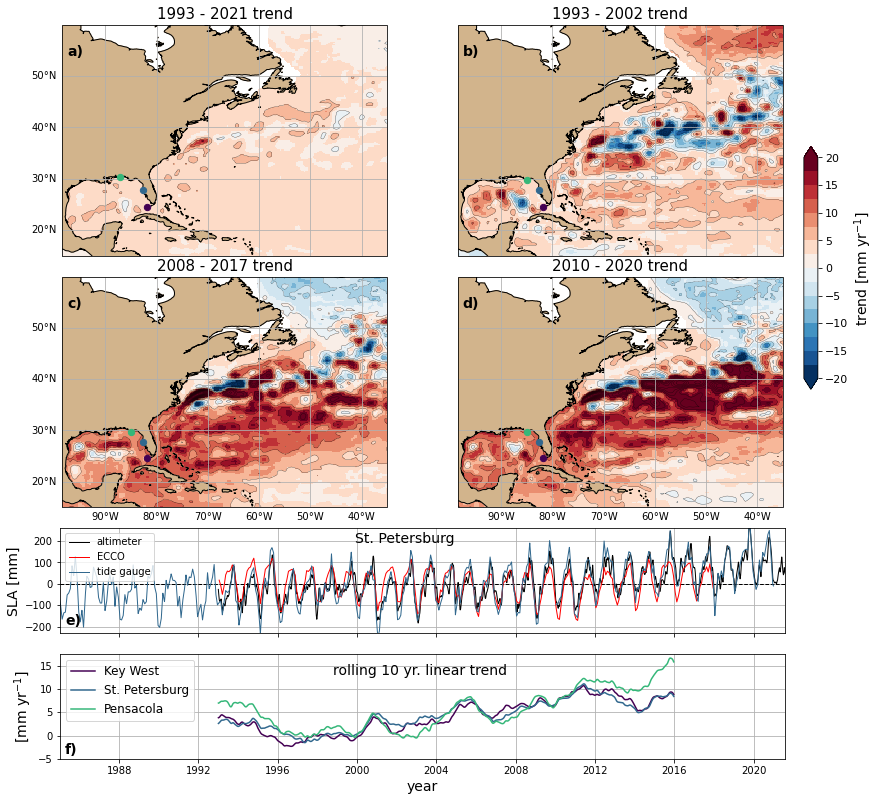

In [44]:
clim = [-0.02, 0.02]; colMap = plt.get_cmap('RdBu_r',16); ax_x = [-98.5,-35]; ax_y = [15,60]; 
fig = plt.figure(tight_layout=False,figsize=(13,13.5)); gs = gridspec.GridSpec(6, 2)
ax0 = fig.add_subplot(gs[0:2, 0],projection=ccrs.PlateCarree(central_longitude=0))
ax1 = fig.add_subplot(gs[0:2, 1],projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[2:4, 0],projection=ccrs.PlateCarree(central_longitude=0))
ax3 = fig.add_subplot(gs[2:4, 1],projection=ccrs.PlateCarree(central_longitude=0))
ax4 = fig.add_subplot(gs[4,:]); ax5 = fig.add_subplot(gs[5,:])
tg_c = plt.get_cmap('viridis',4)
# --- FULL RECORD --- 
Kc = (aviso_tot_sla_trend*365).plot(ax=ax0,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0],vmax=clim[-1],cmap=colMap)
(aviso_tot_sla_trend*365).plot.contour(ax=ax0,transform=ccrs.PlateCarree(),add_colorbar=False,levels=np.arange(-.25,.25,.005),linewidths=0.25,colors='k',zorder=2)
ax0.scatter(tg_xl_a.lon[0],tg_xl_a.lat[0],s=40,color=tg_c(0),transform=ccrs.PlateCarree(),zorder=3)
ax0.scatter(tg_xl_a.lon[3],tg_xl_a.lat[3],s=40,color=tg_c(1),transform=ccrs.PlateCarree(),zorder=3)
ax0.scatter(tg_xl_a.lon[8],tg_xl_a.lat[8],s=40,color=tg_c(2),transform=ccrs.PlateCarree(),zorder=3)
# ax0.scatter(tg_xl_a.lon[13],tg_xl_a.lat[13],s=40,color=tg_c(3),transform=ccrs.PlateCarree(),zorder=3)
ax0.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax0.coastlines(); ax0.set_xlim(ax_x); ax0.set_ylim(ax_y);
gl = ax0.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.xlabels_bottom = False;
ax0.set_title(str(avsla_trend_time_tot[0].data)[0:4] + ' - ' + str(avsla_trend_time_tot[-1].data)[0:4] + ' trend',fontsize=15); ax0.grid()
# --- DECADE 1 --- 
Kc = (aviso_1_sla_trend*365).plot(ax=ax1,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0],vmax=clim[-1],cmap=colMap)
(aviso_1_sla_trend*365).plot.contour(ax=ax1,transform=ccrs.PlateCarree(),add_colorbar=False,levels=np.arange(-.25,.25,.005),linewidths=0.25,colors='k',zorder=2)
ax1.scatter(tg_xl_a.lon[0],tg_xl_a.lat[0],s=40,color=tg_c(0),transform=ccrs.PlateCarree(),zorder=3)
ax1.scatter(tg_xl_a.lon[3],tg_xl_a.lat[3],s=40,color=tg_c(1),transform=ccrs.PlateCarree(),zorder=3)
ax1.scatter(tg_xl_a.lon[6],tg_xl_a.lat[6],s=40,color=tg_c(2),transform=ccrs.PlateCarree(),zorder=3)
# ax1.scatter(tg_xl_a.lon[13],tg_xl_a.lat[13],s=40,color=tg_c(3),transform=ccrs.PlateCarree(),zorder=3)
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax1.coastlines(); ax1.set_xlim(ax_x); ax1.set_ylim(ax_y);
gl = ax1.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = False; gl.xlabels_bottom = False;
ax1.set_title(str(avsla_trend_time_1[0].data)[0:4] + ' - ' + str(avsla_trend_time_1[-1].data)[0:4] + ' trend',fontsize=15)
# --- DECADE 2 --- 
Kc = (aviso_2_sla_trend*365).plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0],vmax=clim[-1],cmap=colMap)
(aviso_2_sla_trend*365).plot.contour(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False,levels=np.arange(-.25,.25,.005),linewidths=0.25,colors='k',zorder=2)
ax2.scatter(tg_xl_a.lon[0],tg_xl_a.lat[0],s=40,color=tg_c(0),transform=ccrs.PlateCarree(),zorder=3)
ax2.scatter(tg_xl_a.lon[3],tg_xl_a.lat[3],s=40,color=tg_c(1),transform=ccrs.PlateCarree(),zorder=3)
ax2.scatter(tg_xl_a.lon[6],tg_xl_a.lat[6],s=40,color=tg_c(2),transform=ccrs.PlateCarree(),zorder=3)
# ax2.scatter(tg_xl_a.lon[13],tg_xl_a.lat[13],s=40,color=tg_c(3),transform=ccrs.PlateCarree(),zorder=3)
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines(); ax2.set_xlim(ax_x); ax2.set_ylim(ax_y);
gl = ax2.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax2.set_title(str(avsla_trend_time_2[0].data)[0:4] + ' - ' + str(avsla_trend_time_2[-1].data)[0:4] + ' trend',fontsize=15)
# --- DECADE 3
Kc = (aviso_3_sla_trend*365*1000).plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0]*1000,vmax=clim[-1]*1000,cmap=colMap)
(aviso_3_sla_trend*365).plot.contour(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False,levels=np.arange(-.25,.25,.005),linewidths=0.25,colors='k',zorder=2)
ax3.scatter(tg_xl_a.lon[0],tg_xl_a.lat[0],s=40,color=tg_c(0),transform=ccrs.PlateCarree(),zorder=3)
ax3.scatter(tg_xl_a.lon[3],tg_xl_a.lat[3],s=40,color=tg_c(1),transform=ccrs.PlateCarree(),zorder=3)
ax3.scatter(tg_xl_a.lon[6],tg_xl_a.lat[6],s=40,color=tg_c(2),transform=ccrs.PlateCarree(),zorder=3)
# ax3.scatter(tg_xl_a.lon[13],tg_xl_a.lat[13],s=40,color=tg_c(3),transform=ccrs.PlateCarree(),zorder=3)
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax3.coastlines(); ax3.set_xlim(ax_x); ax3.set_ylim(ax_y);
gl = ax3.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = False;
ax3.set_title(str(avsla_trend_time_3[0].data)[0:4] + ' - ' + str(avsla_trend_time_3[-1].data)[0:4] + ' trend',fontsize=15)

cbpos = [0.92, 0.505, 0.015, 0.25]; cax = fig.add_axes(cbpos); 
cb = plt.colorbar(Kc, cax=cax, orientation='vertical', extend='both'); cb.ax.tick_params(labelsize=11)
cb.ax.set_ylabel('trend [mm yr$^{-1}$]',fontsize=14); 

# --- SUBPLOT TIMESERIES 1
ax4.plot([data_da_xl.time[5479].data, av_tot.time[-1].data], [0,0], color='k', linestyle='--', linewidth=1)           # zero line (5479)
ax4.plot(av_tot.time, np.array([1000])*av_ts_at_site, label='altimeter',linewidth=1, color='k');                                       # aviso filtered to monthly time scale 
ax4.plot(this_ecco.time, np.array([1000])*this_ecco[:,ecco_i[0][0]-2,ecco_i[1][0]+1].squeeze(), color='r', label='ECCO', linewidth=1)   # #487E30 ecco 
ax4.plot(tg_xl_a.time, np.array([1000])*tg_xl_a.sel(location=ids[3]), color=tg_c(1),linewidth=1,label='tide gauge')                                         # tide gauge over full record (anomaly relative to _l mean and 30 day filter)
ax4.set_xlim([data_da_xl.time[5479], av_tot.time[-1].data]); # ax4.set_xlim([av_tot.time[0].data, av_tot.time[-1].data]);
ax4.set_ylim([-230,260]); ax4.set_ylabel('SLA [mm]',fontsize=14); ax4.grid(); ax4.legend()
ax4.text(time_master[389],190,'St. Petersburg',fontsize=14)
ax4.set_xticklabels('')

ax5.plot(time_master[209:],1000*tg_trend_ts[0,209:],color=tg_c(0),label='Key West') # 469
ax5.plot(time_master[209:],1000*tg_trend_ts[3,209:],color=tg_c(1),label='St. Petersburg')
ax5.plot(time_master[209:],1000*tg_trend_ts[6,209:],color=tg_c(2),label='Pensacola')
# ax5.plot(time_master[209:],1000*tg_trend_ts[7,209:],color=tg_c(3))
ax5.set_xlim([data_da_xl.time[5479], av_tot.time[-1].data]); # ax4.set_xlim([av_tot.time[0].data, av_tot.time[-1].data]);
ax5.set_ylim([-5,17.5]); ax5.set_ylabel('[mm yr$^{-1}$]',fontsize=14); ax5.grid()
ax5.text(time_master[360],13,'rolling 10 yr. linear trend',fontsize=14)
ax5.set_xlabel('year',fontsize=14); ax5.legend(fontsize=12,loc='upper left')

ax0.text(ax_x[0]+1,ax_y[1]-6,'a)',fontsize=14,fontweight='bold'); ax1.text(ax_x[0]+1,ax_y[1]-6,'b)',fontsize=14,fontweight='bold')
ax2.text(ax_x[0]+1,ax_y[1]-6,'c)',fontsize=14,fontweight='bold'); ax3.text(ax_x[0]+1,ax_y[1]-6,'d)',fontsize=14,fontweight='bold')
ax4.text(np.datetime64('1985-04-10'),-190,'e)',fontsize=14,fontweight='bold')
ax5.text(np.datetime64('1985-04-10'),-4,'f)',fontsize=14,fontweight='bold')
# ax2.text(-75,12.5,'Longitude',fontsize=11); ax2.text(-108,32.5,'Latitude',fontsize=11,rotation=90)
fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/r1/f1_aviso_tg_trends.jpg', dpi=400)

In [258]:
time_master[209]

array('1993-01-03T00:00:00.000000000', dtype='datetime64[ns]')

[0, 1, 2, 3, 5, 6, 8, 13, 15]